In [1]:
import numpy as np
from scipy.io import loadmat
from scipy import signal, stats, fft
import matplotlib.pyplot as plt 

Load in vivo data

In [2]:
import pandas as pd

# datafile = '/home/matt/data/InVivoLFPs/BLA_LFP_data/Part2SubjectHB15_AW.mat'
datafile = '/home/matt/data/InVivoLFPs/FengData/LFP_elec_combine.txt'

# data = loadmat(datafile)

def get_feng():
    with open(datafile, 'r') as f:
        data = f.readlines()
    data = np.array(list(map(float, data))).reshape((-1, 1))
    df_list = [pd.DataFrame(data)]
    return df_list

data = get_feng()[0][0].to_numpy()

# fs = data['fs'][0,0]
# scale = data['scale'][0,0]
# print(fs, scale)
fs = 1000
scale = 1  # 0.195
# LFP_seg = [scale*x.ravel() for x in data['LFP_seg'].ravel()]

LFP_cat = data  # np.concatenate(LFP_seg)

Get PSD of in vivo LFP and fit 1/f^a

In [3]:
nfft = 2**8 #7 # 128 samples
print(LFP_cat.shape)

f, Pxx = signal.welch(LFP_cat, fs=fs, window='hamming', nperseg=nfft, scaling='spectrum')
f = f.ravel()

f_cutoff = max(np.argmax(Pxx),1)
Pmax = Pxx[f_cutoff]
idx = np.arange(f_cutoff,f.size)
result = stats.linregress(np.log(f[idx]),np.log(Pxx[idx]))
b = result.intercept
a = -result.slope

f_cutoff = np.exp((b-np.log(Pmax))/a)
idx = f>f_cutoff
Pfit = Pxx.copy()
Pfit[idx] = np.exp(b)/f[idx]**a
Pfit[~idx] = Pmax

(3000001,)


Normalization factors for fourier coefficients in the loss function

In [4]:
norm_factor = np.sqrt(Pmax/Pfit)
print(norm_factor)
# Using FFT with nfft
print(nfft)

[ 1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.02920991  1.12818014
  1.22682046  1.32515939  1.42322098  1.52102577  1.61859153  1.71593374
  1.81306604  1.91000051  2.00674795  2.10331806  2.19971958  2.29596046
  2.39204793  2.48798864  2.58378865  2.67945358  2.77498861  2.87039855
  2.96568788  3.06086076  3.15592107  3.25087248  3.34571839  3.44046203
  3.53510642  3.62965442  3.72410873  3.81847191  3.91274637  4.00693442
  4.10103824  4.19505991  4.28900141  4.38286462  4.47665136  4.57036334
  4.66400221  4.75756955  4.85106687  4.94449563  5.03785722  5.13115298
  5.22438419  5.31755209  5.41065788  5.50370271  5.59668768  5.68961386
  5.78248229  5.87529397  5.96804985  6.06075088  6.15339795  6.24599194
  6.33853369  6.43102402  6.52346374  6.61585361  6.70819438  6.80048677
  6.8927315   6.98492925  7.07708069  7.16918646  7.26124719  7.35326351
  7.44523601  7.53716527  7.62905185  7.72089632  7.8126992

Define function for generating pink noise

In [5]:
def pink_noise(f, alpha=1., fmin=0):
    """
    f: normalized frequencies
    alpha: exponent of pink noise
    fmin: Low-frequency cutoff
    """
    S = 1/np.where(f == 0, float('inf'), f**(alpha/2))
    if fmin>0:
        S[(f<fmin) & (f!=0)] = fmin**(-alpha/2)
    return S

def noise_gen(N, psd = lambda f: 1):
    f = fft.rfftfreq(N)
    Scale = psd(f)
    w = Scale[1:].copy()
    w[-1] *= (1 + (N % 2)) / 2. # correct f = +-0.5
    sigma = 2 * np.sqrt(np.sum(w**2)) / N
    sr = Scale * np.random.randn(len(f))
    si = Scale * np.random.randn(len(f))
    if not (N % 2): si[-1] = 0 # If the signal length is even, frequencies +/- 0.5 are equal, the coefficient must be real.
    si[0] = 0 # Regardless of signal length, the DC component must be real
    s  = sr + 1J * si
    X = fft.irfft(s) / sigma
    return X

Generate pink noise and get its PSD

In [6]:
N = 2**((LFP_cat.size-1).bit_length()-1) # choose power of 2 samples
noise_psd = lambda f: pink_noise(f, alpha=a, fmin=f_cutoff/fs) # function for calculating noise psd
x_noise = np.std(LFP_cat) * noise_gen(N, psd = noise_psd)

_, Pxx_noi = signal.welch(x_noise, fs=fs, window='hamming', nperseg=nfft, scaling='spectrum')

# Compare power in each signal
print(np.std(LFP_cat))
print(np.std(x_noise))

0.04568530058370201
0.045645975375889325


Plot PSD

<IPython.core.display.Javascript object>


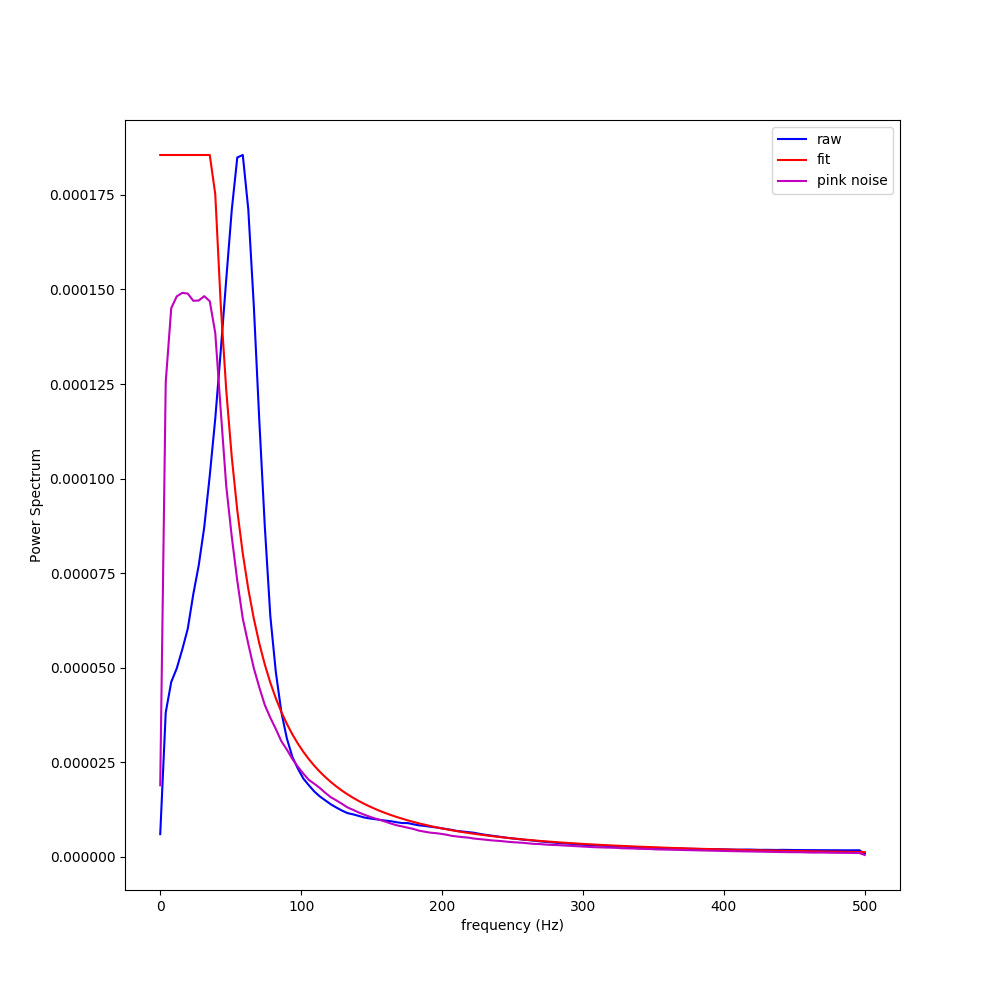

In [7]:
%matplotlib notebook
LinearScale = True

plt.figure(figsize=(8,8))
if LinearScale:
    plt.plot(f, Pxx, 'b', label='raw')
    plt.plot(f, Pfit, 'r', label='fit')
    plt.plot(f, Pxx_noi, 'm', label='pink noise')
else:
    plt.loglog(f, Pxx, 'b', label='raw')
    plt.loglog(f, Pfit, 'r', label='fit')
    plt.loglog(f, Pxx_noi, 'm', label='pink noise')
plt.xlabel("frequency (Hz)")
plt.ylabel("Power Spectrum")
plt.legend()
plt.show()

Plot example pink noise trace

<IPython.core.display.Javascript object>


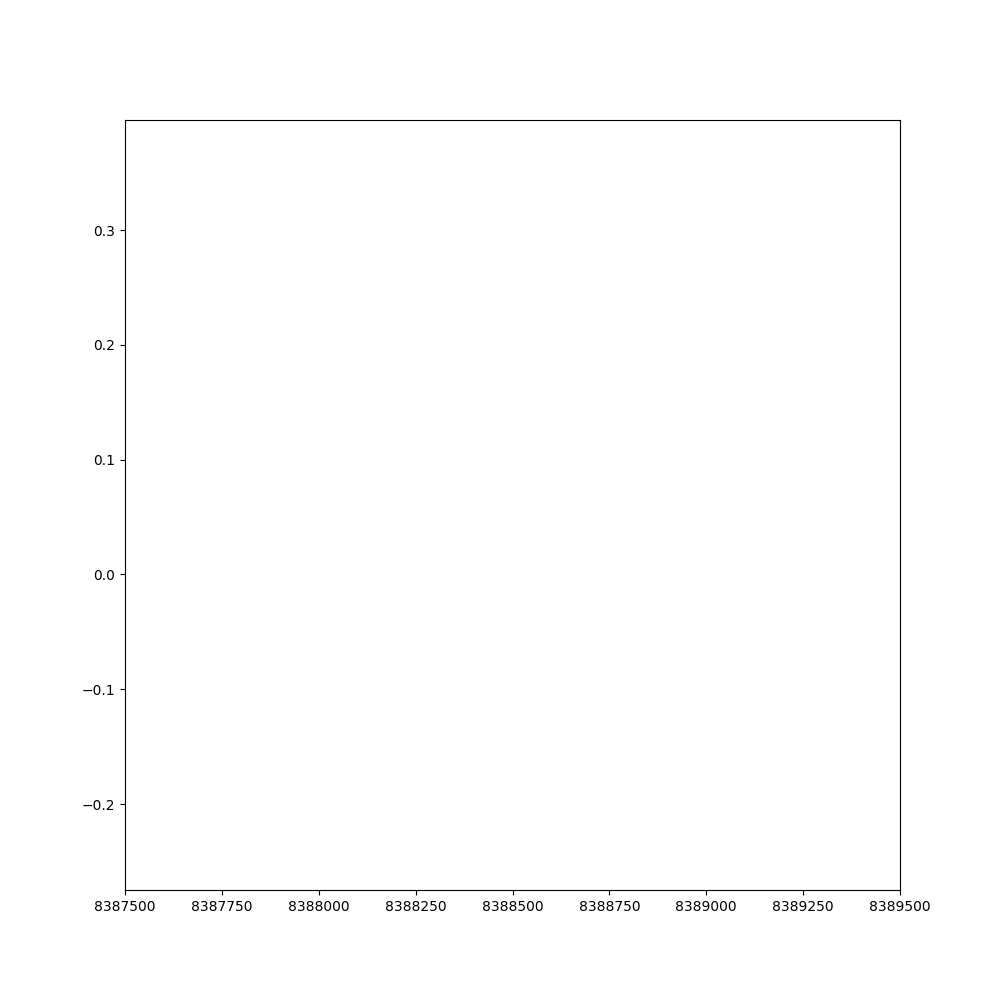

In [8]:
# %matplotlib inline

fig, ax = plt.subplots(figsize=(10,10))
ax.plot(LFP_cat, 'b')
ax.plot(x_noise, 'r')
ax.set_xlim(left=8.3875e6, right=8.3895e6)
plt.show()